# Yelp Review Rating Prediction Using Text
### Tatiana Romanchishina

In [1]:
### libraries
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
import itertools
import random
import scipy
import six
import re

from __future__ import print_function
from pprint import pprint
import time as time
import seaborn as sns
sns.set()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


#### Connect to Amazon S3 storage and download the file

In [2]:
import boto
import boto.s3.connection
from boto.s3.connection import S3Connection
conn = S3Connection()
bucket = conn.get_bucket('yelp-rest-reviews')
for key in bucket.list():
        print ("{name}\t{size}\t{modified}".format(
                name = key.name,
                size = key.size,
                modified = key.last_modified,
                ))

reviews_all.csv	663830339	2016-05-03T17:35:07.000Z


In [3]:
key = bucket.get_key('reviews_all.csv')
key.get_contents_to_filename('/home/ubuntu/yelp/reviews_all.csv')

### Load the data into a dataframe

In [2]:
path = r'/home/ubuntu/yelp/reviews_all.csv'
reviews = pd.read_csv(path)
reviews['Rating_nom'] = ["one" if Rating == 1 else "two" if Rating == 2 else "three" if Rating == 3 
                else "four" if Rating == 4 else "five" for Rating in reviews.Rating]
reviews = reviews[['Text','Rating_nom']]
reviews.head()

,Text,Rating_nom
0,I was underwhelmed I ordered the filet and i...,two
1,Fun environment friendly staff and decent foo...,four
2,Benjamin s is good bar restaurant on the Nort...,five
3,This place is awesome The food is great and t...,five
4,We loved Eddie and his very appeasing accent ...,five


In [13]:
reviews.shape

(990627, 2)

#### Load the necessary Machine Learning libraries

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split

#### Helper function for plotting confusion matrix

In [4]:
labels = ["one","two","three","four","five"]

def plot_confusion(confmat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confmat)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Parameter Tuning

### Multinomial Naive Bayes

In [5]:
reviews_sample = reviews.sample(n = 100000)
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
    ('transformer', TfidfTransformer()),
    ('nbClassifier',  MultinomialNB()) ])

parameters = {
    'vectorizer__ngram_range': ((1,1),(1,2),(1,3)),
    'vectorizer__max_df': (0.6, 0.75),
    'vectorizer__min_df': (1000, 0.01, 0.1),
    'transformer__use_idf': (True, False),
    'nbClassifier__fit_prior': (True, False) 
}
        
if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, cv=2)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(reviews_sample.Text.values, reviews_sample.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vectorizer', 'transformer', 'nbClassifier']
parameters:
{'nbClassifier__fit_prior': (True, False),
 'transformer__use_idf': (True, False),
 'vectorizer__max_df': (0.6, 0.75),
 'vectorizer__min_df': (1000, 0.01, 0.1),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 13.4min finished


done in 843.881s
Best score: 0.525
Best parameters set:
	nbClassifier__fit_prior: False
	transformer__use_idf: False
	vectorizer__max_df: 0.6
	vectorizer__min_df: 0.01
	vectorizer__ngram_range: (1, 2)
[CV] vectorizer__min_df=1000, transformer__use_idf=True, vectorizer__ngram_range=(1, 1), nbClassifier__fit_prior=True, vectorizer__max_df=0.6 
[CV] vectorizer__min_df=1000, transformer__use_idf=True, vectorizer__ngram_range=(1, 1), nbClassifier__fit_prior=True, vectorizer__max_df=0.6 
[CV] vectorizer__min_df=1000, transformer__use_idf=True, vectorizer__ngram_range=(1, 2), nbClassifier__fit_prior=True, vectorizer__max_df=0.6 
[CV] vectorizer__min_df=1000, transformer__use_idf=True, vectorizer__ngram_range=(1, 2), nbClassifier__fit_prior=True, vectorizer__max_df=0.6 
[CV] vectorizer__min_df=1000, transformer__use_idf=True, vectorizer__ngram_range=(1, 3), nbClassifier__fit_prior=True, vectorizer__max_df=0.6 
[CV] vectorizer__min_df=1000, transformer__use_idf=True, vectorizer__ngram_range=(1,

In [49]:
reviews_sample = reviews.sample(n = 500000)
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
  #  ('transformer', TfidfTransformer()),
    ('nbClassifier',  MultinomialNB()) ])

parameters = {
    'vectorizer__ngram_range': ((1,1),(1,2),(1,3)),
    'vectorizer__max_df': (0.5, 0.6, 0.75),
    'vectorizer__min_df': (100, 1000, 0.01, 0.1),
  #  'transformer__use_idf': (True, False),
   # 'nbClassifier__fit_prior': (True, False) 
}
        
if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, cv=2)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(reviews_sample.Text.values, reviews_sample.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vectorizer', 'nbClassifier']
parameters:
{'vectorizer__max_df': (0.5, 0.6, 0.75),
 'vectorizer__min_df': (100, 1000, 0.01, 0.1),
 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 33.9min finished


done in 2217.837s
Best score: 0.576
Best parameters set:
	vectorizer__max_df: 0.5
	vectorizer__min_df: 100
	vectorizer__ngram_range: (1, 2)
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 1), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 1), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 3), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 3), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 1), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 1), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] v

### Multinomial Logistic Regression

See Yelp_Logistic_Regression_all.ipynb

### Support Vector Machines

In [10]:
reviews_sample = reviews.sample(n = 100000)
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english',
                                   max_df=0.6, min_df=0.01)),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('svmClassifier',  SVC()) ])
parameters = {
    'vectorizer__ngram_range': ((1,2),(1,3)),
    'svmClassifier__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
}
        
if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, cv=2)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(reviews_sample.Text.values, reviews_sample.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vectorizer', 'transformer', 'svmClassifier']
parameters:
{'svmClassifier__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
 'vectorizer__ngram_range': ((1, 2), (1, 3))}
Fitting 2 folds for each of 8 candidates, totalling 16 fits
done in 5455.201s
Best score: 0.559
Best parameters set:
	svmClassifier__kernel: 'linear'[CV] svmClassifier__kernel=linear, vectorizer__ngram_range=(1, 2) ....
[CV] svmClassifier__kernel=linear, vectorizer__ngram_range=(1, 2) ....
[CV] svmClassifier__kernel=linear, vectorizer__ngram_range=(1, 3) ....
[CV] svmClassifier__kernel=linear, vectorizer__ngram_range=(1, 3) ....
[CV] svmClassifier__kernel=poly, vectorizer__ngram_range=(1, 2) ......
[CV] svmClassifier__kernel=poly, vectorizer__ngram_range=(1, 2) ......
[CV] svmClassifier__kernel=poly, vectorizer__ngram_range=(1, 3) ......
[CV] svmClassifier__kernel=poly, vectorizer__ngram_range=(1, 3) ......
[CV] svmClassifier__kernel=rbf, vectorizer__ngram_range=(1, 2) .......
[CV] svmClassifier__kernel=rbf, v

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 44.7min finished


In [50]:
reviews_sample = reviews.sample(n = 300000)
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('svmClassifier',  LinearSVC()) ])
parameters = {
    'vectorizer__ngram_range': ((1,2),(1,3)),
    'vectorizer__min_df': (100, 1000, .01),
    'vectorizer__max_df': (0.5, 0.6),
}
        
if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, cv=2)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time.time()
    grid_search.fit(reviews_sample.Text.values, reviews_sample.Rating_nom.values)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['vectorizer', 'transformer', 'svmClassifier']
parameters:
{'vectorizer__max_df': (0.5, 0.6),
 'vectorizer__min_df': (100, 1000, 0.01),
 'vectorizer__ngram_range': ((1, 2), (1, 3))}
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  8.8min finished


done in 677.794s
Best score: 0.572
Best parameters set:
	vectorizer__max_df: 0.5[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 3), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=100, vectorizer__ngram_range=(1, 3), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 3), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=1000, vectorizer__ngram_range=(1, 3), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=0.01, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=0.01, vectorizer__ngram_range=(1, 2), vectorizer__max_df=0.5 
[CV] vectorizer__min_df=0.01, vectorizer__ngram_range=(1, 3), ve

In [51]:
labels = ['one', 'two', 'three', 'four', 'five']
#reviews_sample = reviews.sample(n=1000000)
y = reviews.Rating_nom.values
X = reviews.Text.values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=.4, random_state=123)

In [52]:
len(X_train)

594376

In [53]:
columns = ['pred_svm', 'pred_lr', 'pred_nb','pred_final']
index = np.arange(len(y_test)) # array of numbers for the number of samples
df = pd.DataFrame(columns=columns, index = index)

In [54]:
pipe1 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.5, min_df=100)),
  #  ('transformer', TfidfTransformer(use_idf=False)),
    ('classifier',  MultinomialNB(fit_prior=False)) ])
pipe1 = pipe1.fit(X_train, y_train)
pred_nb = pipe1.predict(X_test)
df.pred_nb = pred_nb

In [55]:
pipe2 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.5, min_df=100)),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('classifier',  LogisticRegression(multi_class='multinomial',solver='lbfgs')) ])
pipe2 = pipe2.fit(X_train, y_train)
pred_lr = pipe2.predict(X_test)
df.pred_lr = pred_lr

In [56]:
pipe3 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.5, min_df=100)),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('classifier',  LinearSVC()) ])
pipe3 = pipe3.fit(X_train, y_train)
pred_svm = pipe3.predict(X_test)
df.pred_svm = pred_svm

In [57]:
df['actual'] = y_test
df.head()

,pred_svm,pred_lr,pred_nb,pred_final,actual
0,five,four,four,NaN,four
1,four,three,three,NaN,four
2,five,four,one,NaN,one
3,one,one,one,NaN,one
4,five,five,five,NaN,five


In [58]:
temp = df

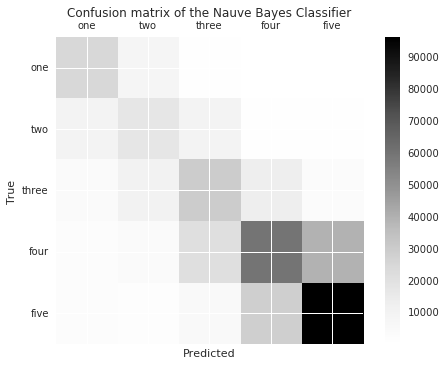

[[24543  8181  1398   309   444]
 [ 9784 17525  9528  1294   767]
 [ 4192 10647 29849 13396  3507]
 [ 2845  4286 21003 59921 39629]
 [ 2411  1865  4456 28116 96355]]
             precision    recall  f1-score   support

        one       0.56      0.70      0.62     34875
        two       0.41      0.45      0.43     38898
      three       0.45      0.48      0.47     61591
       four       0.58      0.47      0.52    127684
       five       0.68      0.72      0.70    133203

avg / total       0.58      0.58      0.57    396251



In [59]:
labels = ['one', 'two', 'three', 'four', 'five']

cm = metrics.confusion_matrix(y_test, df.pred_nb, labels = labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Nauve Bayes Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(metrics.classification_report(y_test, df.pred_nb, labels = labels))

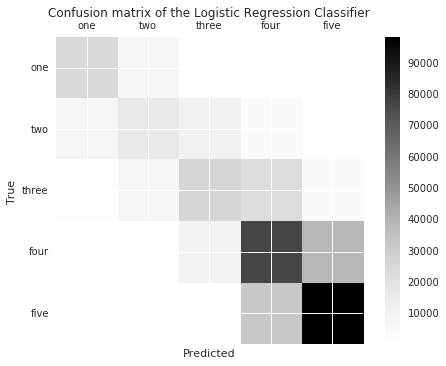

[[24118  7009  1693  1141   914]
 [ 7574 16413 10436  3338  1137]
 [ 1899  7151 26408 22443  3690]
 [  785  1357 10282 76918 38342]
 [  583   437  1510 32354 98319]]
             precision    recall  f1-score   support

        one       0.69      0.69      0.69     34875
        two       0.51      0.42      0.46     38898
      three       0.52      0.43      0.47     61591
       four       0.56      0.60      0.58    127684
       five       0.69      0.74      0.71    133203

avg / total       0.61      0.61      0.61    396251



In [60]:
labels = ['one', 'two', 'three', 'four', 'five']

cm = metrics.confusion_matrix(y_test, df.pred_lr, labels = labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Logistic Regression Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(metrics.classification_report(y_test, df.pred_lr, labels = labels))

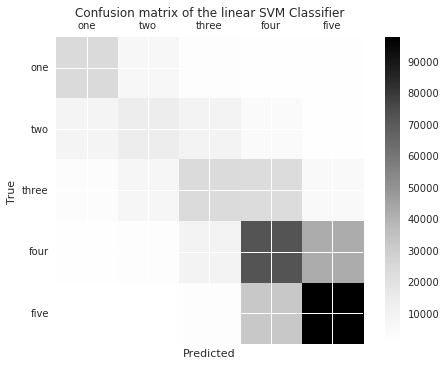

[[24445  6283  1791  1361   995]
 [ 8901 14447  9970  4163  1417]
 [ 2597  7445 23522 23116  4911]
 [ 1027  1749 10277 72610 42021]
 [  600   488  1850 32233 98032]]
             precision    recall  f1-score   support

        one       0.65      0.70      0.67     34875
        two       0.48      0.37      0.42     38898
      three       0.50      0.38      0.43     61591
       four       0.54      0.57      0.56    127684
       five       0.67      0.74      0.70    133203

avg / total       0.58      0.59      0.58    396251



In [61]:
labels = ['one', 'two', 'three', 'four', 'five']

cm = metrics.confusion_matrix(y_test, df.pred_svm, labels = labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the linear SVM Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(metrics.classification_report(y_test, df.pred_svm, labels = labels))

In [62]:
df['actual'] = y_test
df.head()

,pred_svm,pred_lr,pred_nb,pred_final,actual
0,five,four,four,NaN,four
1,four,three,three,NaN,four
2,five,four,one,NaN,one
3,one,one,one,NaN,one
4,five,five,five,NaN,five


In [64]:
mapping = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5}
df = df.replace({'pred_lr': mapping, 'pred_svm': mapping, 'pred_nb': mapping})
df.pred_final = (df.pred_nb+df.pred_svm + df.pred_lr)/3
df.head()

,pred_svm,pred_lr,pred_nb,pred_final,actual
0,5,4,4,4.333333,four
1,4,3,3,3.333333,four
2,5,4,1,3.333333,one
3,1,1,1,1.000000,one
4,5,5,5,5.000000,five


In [65]:
#df.head()
df['pred1'] = df.pred_final.round()
#df.head(20)

In [66]:
mapping = {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five'}
#df = df.replace({'pred1': mapping, 'pred_lr': mapping, 'pred_svm': mapping, 'pred_nb': mapping})
df = df.replace({'pred1': mapping})

In [40]:
#df.head(200)

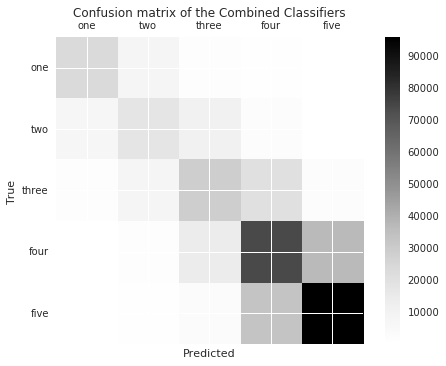

[[23626  8077  2037   872   263]
 [ 7329 17499 11000  2600   470]
 [ 1666  8234 28809 20143  2739]
 [  533  1825 14233 74033 37060]
 [  317   664  2948 33168 96106]]
             precision    recall  f1-score   support

        one       0.71      0.68      0.69     34875
        two       0.48      0.45      0.47     38898
      three       0.49      0.47      0.48     61591
       four       0.57      0.58      0.57    127684
       five       0.70      0.72      0.71    133203

avg / total       0.60      0.61      0.60    396251



In [67]:
labels = ['one', 'two', 'three', 'four', 'five']

cm = metrics.confusion_matrix(y_test, df.pred1, labels = labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Combined Classifiers')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(cm)
print(metrics.classification_report(y_test, df.pred1, labels = labels))

In [70]:
columns = ['LR','SVM','NB']#,'Combined']
index = ['one','two','three','four','five']

precision = pd.DataFrame(columns=columns, index = index)

#precision['Combined'] = [0.71,0.48,0.49,0.57,0.7]
precision['LR'] = [0.69,0.51,0.52,0.56,0.69]
precision['NB'] = [0.56,0.41,0.45,0.58,0.68]
precision['SVM'] = [0.65,0.48,0.50,0.54,0.67]
precision['p_r'] = 'precision'

recall = pd.DataFrame(columns=columns, index = index)
#recall['Combined'] = [0.68,0.45,0.47,0.58,0.72]
recall['LR'] = [0.69,0.42,0.43,0.6,0.74]
recall['NB'] = [0.70,0.45,0.48,0.47,0.72]
recall['SVM'] = [0.7,0.37,0.38,0.57,0.74]
recall['p_r'] = 'recall'

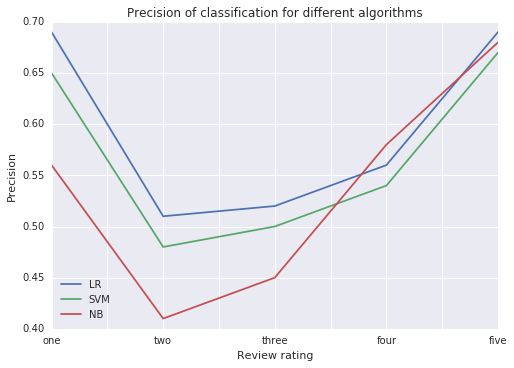

In [71]:
plt.figure(); 
precision.plot(); 
plt.ylabel('Precision')
plt.xlabel('Review rating')
plt.title('Precision of classification for different algorithms')
plt.legend(loc='best')

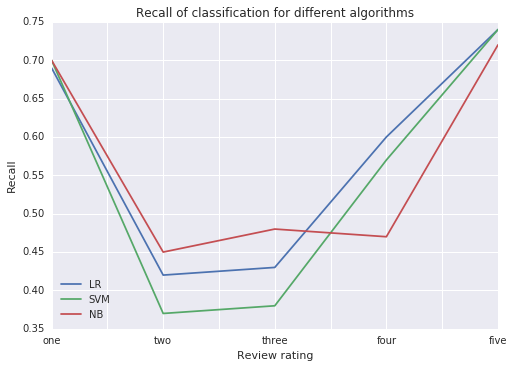

In [72]:
plt.figure(); 
recall.plot();
plt.ylabel('Recall')
plt.xlabel('Review rating')
plt.title('Recall of classification for different algorithms')
plt.legend(loc='best')